In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import boxcox
from collections import Counter
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
import warnings

In [2]:
# loading the imdb_full_info_df and inflation_df
imdb_full_info_df = pd.read_csv('imdb_full_info_df.csv')
inflation_df = pd.read_csv('inflation_data.csv')
cast_score_df = pd.read_csv('cast_score_df.csv')

In [3]:
# processing the inflation_df
inflation_df = inflation_df.sort_values('year', ascending=False)
inflation_df.drop(20, axis=0, inplace=True)
inflation_df.reset_index(inplace=True)
inflation_df.drop(columns=['index'], axis=1, inplace=True)

In [4]:
# calculating the compounded inflation rate for each year with 2019 as base year
for i in range(0, len(inflation_df)):
    if i == 0:
        inflation_df['dollar'][i] = 1
    else:
        inflation_df['dollar'][i] = inflation_df['dollar'][i-1]*(1+inflation_df['inflation'][i-1])

C:\Users\Bosco\AppData\Local\Temp/ipykernel_7900/4206754930.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inflation_df['dollar'][i] = 1
C:\Users\Bosco\AppData\Local\Temp/ipykernel_7900/4206754930.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inflation_df['dollar'][i] = inflation_df['dollar'][i-1]*(1+inflation_df['inflation'][i-1])


In [5]:
# storing the year and compounded rate in a dictionary
inflation_dict = pd.Series(inflation_df.dollar.values, index=inflation_df.year).to_dict()

In [6]:
# adjusting inflation for budget and worldwide_gross
budget_adj = []
worldwide_gross_adj = []

for i in range(0,len(imdb_full_info_df)):
    release_year = int(imdb_full_info_df['release_date'][i].split('-')[0])
    inflation_comp = inflation_dict[release_year]
    budget_adj.append(round(imdb_full_info_df['budget'][i]*inflation_comp))
    worldwide_gross_adj.append(round(imdb_full_info_df['worldwide_gross'][i]*inflation_comp))

imdb_full_info_df['budget_adj'] = budget_adj
imdb_full_info_df['worldwide_gross_adj'] = worldwide_gross_adj

In [7]:
# adding the cast_score column
imdb_full_info_df['cast_score'] = cast_score_df['cast_score']

In [8]:
imdb_full_info_df

,release_date,budget,domestic_gross,worldwide_gross,title,imdb_rating,cast_1,cast_2,cast_3,movie_url,imdb_id,director,rating_check,runtime,genre,director.1,budget_adj,worldwide_gross_adj,cast_score
0,2019-04-23,400000000,858373000,2797800564,Avengers: Endgame,8.4,Robert Downey Jr.,Chris Evans,Mark Ruffalo,https://www.imdb.com/title/tt4154796/,tt4154796,Anthony Russo,8.4,['181'],"['Action', 'Adventure', 'Drama', 'Sci-Fi']",Anthony Russo,400000000,2797800564,761
1,2011-05-20,379000000,241071802,1045713802,Pirates of the Caribbean: On Stranger Tides,6.6,Johnny Depp,Penélope Cruz,Ian McShane,https://www.imdb.com/title/tt1298650/,tt1298650,Rob Marshall,6.6,['137'],"['Action', 'Adventure', 'Fantasy']",Rob Marshall,430707129,1188380976,308
2,2015-04-22,365000000,459005868,1395316979,Avengers: Age of Ultron,7.3,Robert Downey Jr.,Chris Evans,Mark Ruffalo,https://www.imdb.com/title/tt2395427/,tt2395427,Joss Whedon,7.3,['141'],"['Action', 'Adventure', 'Sci-Fi']",Joss Whedon,393679419,1504952267,599
3,2015-12-16,306000000,936662225,2064615817,Star Wars Episode VII: The Force Awakens,7.9,Daisy Ridley,John Boyega,Oscar Isaac,https://www.imdb.com/title/tt2488496/,tt2488496,J.J. Abrams,7.9,['138'],"['Action', 'Adventure', 'Sci-Fi']",J.J. Abrams,330043568,2226840424,0
4,2018-04-25,300000000,678815482,2048359754,Avengers: Infinity War,8.5,Robert Downey Jr.,Chris Hemsworth,Mark Ruffalo,https://www.imdb.com/title/tt4154756/,tt4154756,Anthony Russo,8.5,['149'],"['Action', 'Adventure', 'Sci-Fi']",Anthony Russo,305280000,2084410886,887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,2011-09-30,5000000,223838,5476793,Tucker & Dale vs. Evil,7.5,Tyler Labine,Alan Tudyk,Katrina Bowden,https://www.imdb.com/title/tt1465522/,tt1465522,Eli Craig,7.5,['89'],"['Comedy', 'Horror']",Eli Craig,5682152,6223994,0
3310,2007-11-16,5000000,65388,861325,Redacted,6.1,Patrick Carroll,Rob Devaney,Izzy Diaz,https://www.imdb.com/title/tt0937237/,tt0937237,Brian De Palma,6.1,['90'],"['Crime', 'Thriller', 'War']",Brian De Palma,6164349,1061902,0
3311,2014-10-17,5000000,56001,584499,Rudderless,7.4,Billy Crudup,Anton Yelchin,Felicity Huffman,https://www.imdb.com/title/tt1798243/,tt1798243,William H. Macy,7.4,['105'],"['Comedy', 'Drama', 'Music']",William H. Macy,5399340,631182,0
3312,2012-05-17,5000000,0,9109597,Mientras duermes,7.2,Luis Tosar,Marta Etura,Alberto San Juan,https://www.imdb.com/title/tt1437358/,tt1437358,Jaume Balagueró,7.2,['102'],"['Crime', 'Drama', 'Thriller']",Jaume Balagueró,5566917,10142474,0


In [9]:
# extracting runtime values
runtime = []
for i in imdb_full_info_df['runtime']:
    runtime.append(int(i[2:][:-2]))
    
imdb_full_info_df['runtime'] = runtime

In [10]:
# dropping irrelevant columns
imdb_full_info_df.drop(columns=['release_date', 'domestic_gross', 'title', 'cast_1', 'cast_2', 'cast_3', 'movie_url', 'imdb_id', 'director', 'director.1','rating_check'], inplace=True)
imdb_full_info_df

,budget,worldwide_gross,imdb_rating,runtime,genre,budget_adj,worldwide_gross_adj,cast_score
0,400000000,2797800564,8.4,181,"['Action', 'Adventure', 'Drama', 'Sci-Fi']",400000000,2797800564,761
1,379000000,1045713802,6.6,137,"['Action', 'Adventure', 'Fantasy']",430707129,1188380976,308
2,365000000,1395316979,7.3,141,"['Action', 'Adventure', 'Sci-Fi']",393679419,1504952267,599
3,306000000,2064615817,7.9,138,"['Action', 'Adventure', 'Sci-Fi']",330043568,2226840424,0
4,300000000,2048359754,8.5,149,"['Action', 'Adventure', 'Sci-Fi']",305280000,2084410886,887
...,...,...,...,...,...,...,...,...
3309,5000000,5476793,7.5,89,"['Comedy', 'Horror']",5682152,6223994,0
3310,5000000,861325,6.1,90,"['Crime', 'Thriller', 'War']",6164349,1061902,0
3311,5000000,584499,7.4,105,"['Comedy', 'Drama', 'Music']",5399340,631182,0
3312,5000000,9109597,7.2,102,"['Crime', 'Drama', 'Thriller']",5566917,10142474,0


### 0. Base Modelling
#### budget-adjusted, imdb-rating, imdb-runtime, cast-score

In [13]:
def modelling(X, y, z):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 100)
    std_scaler = StandardScaler().fit(X_train)
    X_train_scaled = std_scaler.transform(X_train)
    X_test_scaled = std_scaler.transform(X_test)
    model = z
    model.fit(X_train_scaled, y_train)
    print('Train score is: '+str(model.score(X_train_scaled, y_train)))
    print('Test score is: '+str(model.score(X_test_scaled, y_test)))
    Adj_R2 = 1-((1-model.score(X_test_scaled, y_test))*(len(y_test)-1)/((len(y_test)-X_test.shape[1]-1)))
    print('Adjusted R2 is: '+str(Adj_R2))
    features_importance = pd.DataFrame(data = {
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)
    })
    features_importance = features_importance.sort_values(by='Importance', ascending=False)
    return features_importance

In [106]:
modelling(imdb_full_info_df.drop(['worldwide_gross_adj', 'genre', 'budget', 'worldwide_gross'], axis=1), imdb_full_info_df['worldwide_gross_adj'], LinearRegression())

Train score is: 0.5836853051313406
Test score is: 0.5682744782605578
Adjusted R2 is: 0.5656500070037831


,Attribute,Importance
2,budget_adj,1.763490e+08
0,imdb_rating,4.686488e+07
3,cast_score,8.579931e+06
1,runtime,6.970999e+06


### 1. Modelling - Linear Regression
#### budget-adjusted, imdb-rating, imdb-runtime, imdb-genre, cast-score

In [15]:
# one hot encoding for genre (multiple values)
x = imdb_full_info_df['genre'].apply(eval)
x = x.apply(Counter)
x = pd.json_normalize(x)
x = x.replace(np.nan, 0)
x = x.astype('int')

In [16]:
# merging two dataframes
model1_df = pd.concat([imdb_full_info_df, x], axis=1)
model1_df

,budget,worldwide_gross,imdb_rating,runtime,genre,budget_adj,worldwide_gross_adj,cast_score,Action,Adventure,...,Crime,Western,History,Sport,Horror,Music,War,Biography,Documentary,Short
0,400000000,2797800564,8.4,181,"['Action', 'Adventure', 'Drama', 'Sci-Fi']",400000000,2797800564,761,1,1,...,0,0,0,0,0,0,0,0,0,0
1,379000000,1045713802,6.6,137,"['Action', 'Adventure', 'Fantasy']",430707129,1188380976,308,1,1,...,0,0,0,0,0,0,0,0,0,0
2,365000000,1395316979,7.3,141,"['Action', 'Adventure', 'Sci-Fi']",393679419,1504952267,599,1,1,...,0,0,0,0,0,0,0,0,0,0
3,306000000,2064615817,7.9,138,"['Action', 'Adventure', 'Sci-Fi']",330043568,2226840424,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,300000000,2048359754,8.5,149,"['Action', 'Adventure', 'Sci-Fi']",305280000,2084410886,887,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,5000000,5476793,7.5,89,"['Comedy', 'Horror']",5682152,6223994,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3310,5000000,861325,6.1,90,"['Crime', 'Thriller', 'War']",6164349,1061902,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3311,5000000,584499,7.4,105,"['Comedy', 'Drama', 'Music']",5399340,631182,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3312,5000000,9109597,7.2,102,"['Crime', 'Drama', 'Thriller']",5566917,10142474,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [315]:
# NOT USED!!
# one hot encoding for genre (multiple values) - alternative
genre = []
for i in imdb_full_info_df['genre']:
    genre.append((i[2:][:-2]).replace("'","").replace(', ',','))
    
imdb_full_info_df['genre'] = genre

# finding unique values for genre
genre_cat = imdb_full_info_df['genre'].value_counts().reset_index()
genre_cat.head

genre_cat.rename(columns={'index':'genre_name', 'genre':'count'}, inplace=True)

genre_cat['genre_name'] = genre_cat['genre_name'].str.split(',')

df1 = []
for i in range(genre_cat.shape[0]):
    for j in genre_cat['genre_name'][i]:
        df1.append(j)
        
# creating a list of unique genres
list1 = list(set(df1))
list1

# creating a new dataframe with genre columns
df2 = pd.DataFrame(columns=list1)

# merging two dataframes
df3 = pd.concat([imdb_full_info_df, df2], axis=1)
df3

# filling binary values for genre columns
for i in range(0, len(df3)):
    for j in range(0, len(list1)):
        if df3.columns[5+j]in df3['genre'][i]:
            df3[df3.columns[5+j]][i] = 1
        else:
            df3[df3.columns[5+j]][i] = 0

In [17]:
model1_df.drop(['genre', 'budget', 'worldwide_gross'], axis=1, inplace=True)
model1_df

,imdb_rating,runtime,budget_adj,worldwide_gross_adj,cast_score,Action,Adventure,Drama,Sci-Fi,Fantasy,...,Crime,Western,History,Sport,Horror,Music,War,Biography,Documentary,Short
0,8.4,181,400000000,2797800564,761,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,6.6,137,430707129,1188380976,308,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,7.3,141,393679419,1504952267,599,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,7.9,138,330043568,2226840424,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,8.5,149,305280000,2084410886,887,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,7.5,89,5682152,6223994,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3310,6.1,90,6164349,1061902,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3311,7.4,105,5399340,631182,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3312,7.2,102,5566917,10142474,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [18]:
modelling(model1_df.drop('worldwide_gross_adj', axis=1), model1_df['worldwide_gross_adj'], LinearRegression())

Train score is: 0.6167697614703315
Test score is: 0.6055772676365117
Adjusted R2 is: 0.589453067885803


,Attribute,Importance
2,budget_adj,1.550515e+08
0,imdb_rating,5.540795e+07
6,Drama,2.710093e+07
5,Adventure,1.592802e+07
20,Horror,1.413640e+07
3,cast_score,1.401386e+07
1,runtime,1.336281e+07
17,Western,1.259715e+07
9,Thriller,1.195364e+07
4,Action,8.934558e+06


In [604]:
modelling(model1_df.drop('worldwide_gross_adj', axis=1), model1_df['worldwide_gross_adj'], Ridge(alpha=100.0))

Train score is: 0.6132132037502929
Test score is: 0.5975317939557374
Adjusted R2 is: 0.5817363384594947


,Attribute,Importance
2,budget_adj,1.515177e+08
0,imdb_rating,5.391711e+07
5,Drama,2.718846e+07
1,runtime,1.664271e+07
4,Adventure,1.658423e+07
16,Western,1.160360e+07
8,Thriller,1.109928e+07
19,Horror,1.085583e+07
21,War,8.903713e+06
17,History,8.793743e+06


In [44]:
# loading the Rotten Tomatoes data
rt_df = pd.read_csv('year_difference_Biagio_8_march_modif.csv', sep=';')
rt_df

,Unnamed: 0,release_date,budget,domestic_gross,worldwide_gross,title,imdb_rating,cast_1,cast_2,cast_3,runtime,genre,director,tomatometer_score,audience_score_rt,original_language,MPA_Ratings,Year_scraped,release_year,difference
0,0,4/23/2019,400000000,858373000,2797800564,Avengers: Endgame,8.4,Robert Downey Jr.,Chris Evans,Mark Ruffalo,['181'],"['Action', 'Adventure', 'Drama', 'Sci-Fi']",Anthony Russo,94.0,90.0,English,PG-13,2019.0,2019,0.0
1,1,5/20/2011,379000000,241071802,1045713802,Pirates of the Caribbean: On Stranger Tides,6.6,Johnny Depp,Pen√©lope Cruz,Ian McShane,['137'],"['Action', 'Adventure', 'Fantasy']",Rob Marshall,33.0,54.0,English,PG-13,2011.0,2011,0.0
2,2,4/22/2015,365000000,459005868,1395316979,Avengers: Age of Ultron,7.3,Robert Downey Jr.,Chris Evans,Mark Ruffalo,['141'],"['Action', 'Adventure', 'Sci-Fi']",Joss Whedon,76.0,83.0,English,PG-13,2015.0,2015,0.0
3,3,12/16/2015,306000000,936662225,2064615817,Star Wars Episode VII: The Force Awakens,7.9,Daisy Ridley,John Boyega,Oscar Isaac,['138'],"['Action', 'Adventure', 'Sci-Fi']",J.J. Abrams,93.0,85.0,English,PG-13,2015.0,2015,0.0
4,4,4/25/2018,300000000,678815482,2048359754,Avengers: Infinity War,8.5,Robert Downey Jr.,Chris Hemsworth,Mark Ruffalo,['149'],"['Action', 'Adventure', 'Sci-Fi']",Anthony Russo,85.0,91.0,English,PG-13,2018.0,2018,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,3309,9/30/2011,5000000,223838,5476793,Tucker & Dale vs. Evil,7.5,Tyler Labine,Alan Tudyk,Katrina Bowden,['89'],"['Comedy', 'Horror']",Eli Craig,85.0,85.0,English,R,NaN,2011,NaN
3310,3310,11/16/2007,5000000,65388,861325,Redacted,6.1,Patrick Carroll,Rob Devaney,Izzy Diaz,['90'],"['Crime', 'Thriller', 'War']",Brian De Palma,45.0,45.0,English,R,NaN,2007,NaN
3311,3311,10/17/2014,5000000,56001,584499,Rudderless,7.4,Billy Crudup,Anton Yelchin,Felicity Huffman,['105'],"['Comedy', 'Drama', 'Music']",William H. Macy,64.0,83.0,English,R,NaN,2014,NaN
3312,3312,5/17/2012,5000000,0,9109597,Mientras duermes,7.2,Luis Tosar,Marta Etura,Alberto San Juan,['102'],"['Crime', 'Drama', 'Thriller']",Jaume Balaguer√≥,91.0,78.0,Spanish,NaN,NaN,2012,NaN


### 2. Modelling - Linear Regression
#### budget-adjusted, imdb-rating, imdb-runtime, rt-critic-rating, rt-audience-rating

In [58]:
rt2_df = rt_df[['tomatometer_score', 'audience_score_rt']]

In [61]:
model2_df = imdb_full_info_df.drop(['genre', 'budget', 'worldwide_gross'], axis=1)
model2_df

,imdb_rating,runtime,budget_adj,worldwide_gross_adj,cast_score
0,8.4,181,400000000,2797800564,761
1,6.6,137,430707129,1188380976,308
2,7.3,141,393679419,1504952267,599
3,7.9,138,330043568,2226840424,0
4,8.5,149,305280000,2084410886,887
...,...,...,...,...,...
3309,7.5,89,5682152,6223994,0
3310,6.1,90,6164349,1061902,0
3311,7.4,105,5399340,631182,0
3312,7.2,102,5566917,10142474,0


In [62]:
model2_df = pd.concat([model2_df, rt2_df], axis=1)
model2_df

,imdb_rating,runtime,budget_adj,worldwide_gross_adj,cast_score,tomatometer_score,audience_score_rt
0,8.4,181,400000000,2797800564,761,94.0,90.0
1,6.6,137,430707129,1188380976,308,33.0,54.0
2,7.3,141,393679419,1504952267,599,76.0,83.0
3,7.9,138,330043568,2226840424,0,93.0,85.0
4,8.5,149,305280000,2084410886,887,85.0,91.0
...,...,...,...,...,...,...,...
3309,7.5,89,5682152,6223994,0,85.0,85.0
3310,6.1,90,6164349,1061902,0,45.0,45.0
3311,7.4,105,5399340,631182,0,64.0,83.0
3312,7.2,102,5566917,10142474,0,91.0,78.0


In [64]:
model2_df.dropna(inplace=True)

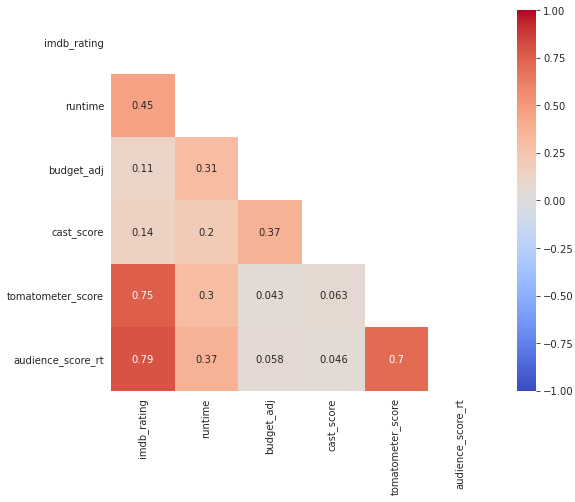

In [84]:
# checking multicollinearity
corr = model2_df.drop('worldwide_gross_adj', axis=1).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

In [65]:
modelling(model2_df.drop('worldwide_gross_adj', axis=1), model2_df['worldwide_gross_adj'], LinearRegression())

Train score is: 0.5975646633488612
Test score is: 0.5734264769680579
Adjusted R2 is: 0.5694767221251695


,Attribute,Importance
2,budget_adj,1.797813e+08
5,audience_score_rt,3.148897e+07
4,tomatometer_score,2.578109e+07
3,cast_score,1.145739e+07
1,runtime,8.391408e+06
0,imdb_rating,2.156946e+06


### 2.1 Modelling - Linear Regression (Investigating The Ratings)
#### budget-adjusted, imdb-rating/rt-critic-rating/ rt-audience-rating

In [87]:
model2_1_df = model2_df[['budget_adj', 'imdb_rating']]

In [89]:
modelling(model2_1_df, model2_df['worldwide_gross_adj'], LinearRegression())

Train score is: 0.583040751670133
Test score is: 0.5553857666755783
Adjusted R2 is: 0.5540219193340923


,Attribute,Importance
0,budget_adj,1.796022e+08
1,imdb_rating,4.473783e+07


In [90]:
model2_2_df = model2_df[['budget_adj', 'audience_score_rt']]

In [91]:
modelling(model2_2_df, model2_df['worldwide_gross_adj'], LinearRegression())

Train score is: 0.5891684887263096
Test score is: 0.569813126365925
Adjusted R2 is: 0.5684935347290105


,Attribute,Importance
0,budget_adj,1.818583e+08
1,audience_score_rt,4.861056e+07


In [92]:
model2_3_df = model2_df[['budget_adj', 'tomatometer_score']]

In [93]:
modelling(model2_3_df, model2_df['worldwide_gross_adj'], LinearRegression())

Train score is: 0.5876600142452257
Test score is: 0.5508319337444215
Adjusted R2 is: 0.5494541175902633


,Attribute,Importance
0,budget_adj,1.824710e+08
1,tomatometer_score,4.761169e+07


### 3. Modelling - Linear Regression
#### budget-adjusted, imdb-rating, imdb-runtime, imdb-genre, rt-critic-rating, rt-audience-rating

In [97]:
model3_df = pd.concat([model1_df, rt2_df], axis=1)

In [98]:
model3_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3314 entries, 0 to 3313
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   imdb_rating          3314 non-null   float64
 1   runtime              3314 non-null   int64  
 2   budget_adj           3314 non-null   int64  
 3   worldwide_gross_adj  3314 non-null   int64  
 4   cast_score           3314 non-null   int64  
 5   Action               3314 non-null   int32  
 6   Adventure            3314 non-null   int32  
 7   Drama                3314 non-null   int32  
 8   Sci-Fi               3314 non-null   int32  
 9   Fantasy              3314 non-null   int32  
 10  Thriller             3314 non-null   int32  
 11  Animation            3314 non-null   int32  
 12  Family               3314 non-null   int32  
 13  Musical              3314 non-null   int32  
 14  Comedy               3314 non-null   int32  
 15  Romance              3314 non-null   i

In [99]:
model3_df.isna().sum()

imdb_rating             0
runtime                 0
budget_adj              0
worldwide_gross_adj     0
cast_score              0
Action                  0
Adventure               0
Drama                   0
Sci-Fi                  0
Fantasy                 0
Thriller                0
Animation               0
Family                  0
Musical                 0
Comedy                  0
Romance                 0
Mystery                 0
Crime                   0
Western                 0
History                 0
Sport                   0
Horror                  0
Music                   0
War                     0
Biography               0
Documentary             0
Short                   0
tomatometer_score      38
audience_score_rt       9
dtype: int64

In [100]:
model3_df.dropna(inplace=True)

In [103]:
modelling(model3_df.drop('worldwide_gross_adj', axis=1), model3_df['worldwide_gross_adj'], LinearRegression())

Train score is: 0.632636258271245
Test score is: 0.5892579534735992
Adjusted R2 is: 0.5708861047471787


,Attribute,Importance
2,budget_adj,1.582966e+08
27,audience_score_rt,3.147480e+07
6,Drama,3.135835e+07
26,tomatometer_score,1.943069e+07
5,Adventure,1.695924e+07
0,imdb_rating,1.674201e+07
3,cast_score,1.598863e+07
4,Action,1.443827e+07
20,Horror,1.333046e+07
1,runtime,1.232097e+07


### 4. Modelling - Linear Regression
#### budget-adjusted, imdb-rating, imdb-runtime, imdb-genre, rt-critic-rating, rt-audience-rating, rt-language, rt-mpa-rating

In [71]:
# checking categories of MPA_Ratings
rt_df['MPA_Ratings'].value_counts().index

Index(['PG-13', 'R', 'PG', 'G', 'NC-17', 'TVMA', 'NR'], dtype='object')

In [72]:
# removing space inide string
rt_df['MPA_Ratings'] = rt_df['MPA_Ratings'].str.strip()

In [73]:
# standardizing data
rt_df['MPA_Ratings'].replace({'PG_13':'PG-13'}, inplace=True)

In [74]:
rt_df['MPA_Ratings'].value_counts()

PG-13    1328
R        1286
PG        501
G          76
NC-17       3
TVMA        2
NR          1
Name: MPA_Ratings, dtype: int64

In [75]:
rt3_df = rt_df[['tomatometer_score', 'audience_score_rt', 'original_language', 'MPA_Ratings']]

In [76]:
# merging two dataframes
model3_df = pd.concat([model1_df, rt3_df], axis=1)
model3_df

,imdb_rating,runtime,budget_adj,worldwide_gross_adj,cast_score,Action,Adventure,Drama,Sci-Fi,Fantasy,...,Horror,Music,War,Biography,Documentary,Short,tomatometer_score,audience_score_rt,original_language,MPA_Ratings
0,8.4,181,400000000,2797800564,761,1,1,1,1,0,...,0,0,0,0,0,0,94.0,90.0,English,PG-13
1,6.6,137,430707129,1188380976,308,1,1,0,0,1,...,0,0,0,0,0,0,33.0,54.0,English,PG-13
2,7.3,141,393679419,1504952267,599,1,1,0,1,0,...,0,0,0,0,0,0,76.0,83.0,English,PG-13
3,7.9,138,330043568,2226840424,0,1,1,0,1,0,...,0,0,0,0,0,0,93.0,85.0,English,PG-13
4,8.5,149,305280000,2084410886,887,1,1,0,1,0,...,0,0,0,0,0,0,85.0,91.0,English,PG-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,7.5,89,5682152,6223994,0,0,0,0,0,0,...,1,0,0,0,0,0,85.0,85.0,English,R
3310,6.1,90,6164349,1061902,0,0,0,0,0,0,...,0,0,1,0,0,0,45.0,45.0,English,R
3311,7.4,105,5399340,631182,0,0,0,1,0,0,...,0,1,0,0,0,0,64.0,83.0,English,R
3312,7.2,102,5566917,10142474,0,0,0,1,0,0,...,0,0,0,0,0,0,91.0,78.0,Spanish,NaN


In [77]:
model3_df.dropna(inplace=True)
model3_df

,imdb_rating,runtime,budget_adj,worldwide_gross_adj,cast_score,Action,Adventure,Drama,Sci-Fi,Fantasy,...,Horror,Music,War,Biography,Documentary,Short,tomatometer_score,audience_score_rt,original_language,MPA_Ratings
0,8.4,181,400000000,2797800564,761,1,1,1,1,0,...,0,0,0,0,0,0,94.0,90.0,English,PG-13
1,6.6,137,430707129,1188380976,308,1,1,0,0,1,...,0,0,0,0,0,0,33.0,54.0,English,PG-13
2,7.3,141,393679419,1504952267,599,1,1,0,1,0,...,0,0,0,0,0,0,76.0,83.0,English,PG-13
3,7.9,138,330043568,2226840424,0,1,1,0,1,0,...,0,0,0,0,0,0,93.0,85.0,English,PG-13
4,8.5,149,305280000,2084410886,887,1,1,0,1,0,...,0,0,0,0,0,0,85.0,91.0,English,PG-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,6.4,96,5486810,1179674,142,0,0,1,0,0,...,0,0,0,0,0,0,77.0,61.0,English,R
3307,5.7,118,5399340,1001118,84,0,0,1,0,0,...,0,1,0,1,0,0,67.0,36.0,English,R
3309,7.5,89,5682152,6223994,0,0,0,0,0,0,...,1,0,0,0,0,0,85.0,85.0,English,R
3310,6.1,90,6164349,1061902,0,0,0,0,0,0,...,0,0,1,0,0,0,45.0,45.0,English,R


In [78]:
model3_num = model3_df._get_numeric_data()
model3_num.columns

Index(['imdb_rating', 'runtime', 'budget_adj', 'worldwide_gross_adj',
       'cast_score', 'Action', 'Adventure', 'Drama', 'Sci-Fi', 'Fantasy',
       'Thriller', 'Animation', 'Family', 'Musical', 'Comedy', 'Romance',
       'Mystery', 'Crime', 'Western', 'History', 'Sport', 'Horror', 'Music',
       'War', 'Biography', 'Documentary', 'Short', 'tomatometer_score',
       'audience_score_rt'],
      dtype='object')

In [79]:
model3_cat = model3_df.select_dtypes('object')
model3_cat.columns

Index(['original_language', 'MPA_Ratings'], dtype='object')

In [80]:
model3_cat = pd.get_dummies(model3_cat, drop_first=True)
model3_cat

,original_language_Aramaic,original_language_Bosnian,original_language_Catalan,original_language_Chinese,original_language_Czech,original_language_Danish,original_language_Dutch,original_language_English,original_language_English (Australia),original_language_English (United Kingdom),...,original_language_Spanish (Spain),original_language_Swedish,original_language_Tamil,original_language_Thai,original_language_Unknown language,MPA_Ratings_NC-17,MPA_Ratings_PG,MPA_Ratings_PG-13,MPA_Ratings_R,MPA_Ratings_TVMA
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3307,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3309,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3310,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [81]:
model3_combined = pd.concat([model3_num, model3_cat], axis=1)
model3_combined

,imdb_rating,runtime,budget_adj,worldwide_gross_adj,cast_score,Action,Adventure,Drama,Sci-Fi,Fantasy,...,original_language_Spanish (Spain),original_language_Swedish,original_language_Tamil,original_language_Thai,original_language_Unknown language,MPA_Ratings_NC-17,MPA_Ratings_PG,MPA_Ratings_PG-13,MPA_Ratings_R,MPA_Ratings_TVMA
0,8.4,181,400000000,2797800564,761,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
1,6.6,137,430707129,1188380976,308,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,7.3,141,393679419,1504952267,599,1,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,7.9,138,330043568,2226840424,0,1,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,8.5,149,305280000,2084410886,887,1,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,6.4,96,5486810,1179674,142,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3307,5.7,118,5399340,1001118,84,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3309,7.5,89,5682152,6223994,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3310,6.1,90,6164349,1061902,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [82]:
modelling(model3_combined.drop('worldwide_gross_adj', axis=1), model3_combined['worldwide_gross_adj'], LinearRegression())

Train score is: 0.6385540045999595
Test score is: -2.4616766244507044e+21
Adjusted R2 is: -2.713827528691315e+21


,Attribute,Importance
33,original_language_Danish,3.126541e+20
51,original_language_Tamil,2.514801e+19
25,Short,1.081290e+17
2,budget_adj,1.527850e+08
27,audience_score_rt,3.208023e+07
6,Drama,2.888320e+07
26,tomatometer_score,2.275300e+07
1,runtime,1.819124e+07
3,cast_score,1.536148e+07
20,Horror,1.534021e+07
